## Imports and Functions

In [1]:
import tensorflow as tf
from skimage.transform import resize
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
import cv2
from tensorflow.keras.models import Model
from skimage.util import random_noise
from ipywidgets import interact
import json
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
def model_training(train_X,train_y,test_X,test_y,epochs=5):
    model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(64,64,3),   
    )
    gm = tf.keras.layers.GlobalMaxPooling2D()(model.output)
    dense1 =tf.keras.layers.Dense(512,activation='relu')(gm)
    dense2 =tf.keras.layers.Dense(256,activation='relu')(dense1)
    dense3 =tf.keras.layers.Dense(128,activation='relu')(dense2)
    dense4 =tf.keras.layers.Dense(64,activation='relu')(dense3)
    output =tf.keras.layers.Dense(10,activation='softmax')(dense4)
    mnist_model = tf.keras.models.Model(inputs = model.input , outputs = output)
    mnist_model.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
    history= mnist_model.fit(x=train_X, y=train_y, validation_data=(test_X,test_y),epochs=epochs,batch_size=512)
    return mnist_model

In [3]:
def find_misclassifications(model,test_X,test_y):
    predictions_normal= model.predict(test_X)
    wrong_inputs_normal=[]
    wrong_outputs_normal=[]
    wrong_outputs_original_normal=[]
    for i in range(len(predictions_normal)):
        if np.argmax(test_y[i]) != np.argmax(predictions_normal[i]):
            wrong_inputs_normal.append(test_X[i])
            wrong_outputs_normal.append(np.argmax(predictions_normal[i]))
            wrong_outputs_original_normal.append(np.argmax(test_y[i]) )
    dic={}
    for i in zip(wrong_outputs_normal,wrong_outputs_original_normal):
        k=[int(i[0]),int(i[1])]
        s=json.dumps(k)
        try:
            dic[s]+=1
        except:
            dic[s]=1
    plt.figure(figsize=(25,10))
    plt.bar(range(len(dic)), list(dic.values()), align='center')
    plt.xticks(range(len(dic)), list(dic.keys()))
    plt.xlabel('Misclassified Numbers')
    plt.ylabel('Count')
    plt.show()
    return predictions_normal,wrong_inputs_normal,wrong_outputs_normal,wrong_outputs_original_normal,dic



In [4]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb
def fuse_layers(layers, model, img, emphasize=False):
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)

  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.1, emphasize=emphasize)
  #cv2.imwrite('grad_new_vgg/'+count+'.jpg')
  return superimposed,cams


In [5]:
def get_grad_array(arr,model=None,flag=0):
    grads=[]
    for image in arr:
        
        if flag==0:
            sp,cams=fuse_layers(conv2D_layers,mnist_model,cv2.cvtColor(image.astype('float32'), cv2.COLOR_RGB2BGR))
            #print(len(cams))
            sp= np.mean(cams[-6:],axis=0)
            
        elif flag==1:
            sp,cams=fuse_layers(conv2D_layers,mnist_model,cv2.cvtColor(image.astype('float32'), cv2.COLOR_RGB2BGR))
        else:
            cam = GradCam(model, np.expand_dims(image, axis=0), conv2D_layers[-1])
            sp = superimpose(image, cam, 0.1, emphasize=False)
        
        grads.append(sp)
    return grads

In [6]:
def create_misc_array(x,y,wrong_inputs_normal,wrong_outputs_normal,wrong_outputs_original_normal):
    m_arr=[]
    for i in range(len(wrong_inputs_normal)):
        if x==wrong_outputs_normal[i] and y ==wrong_outputs_original_normal[i]:
            m_arr.append(wrong_inputs_normal[i])
    return m_arr

In [113]:
def plot_misclassifications(n,arr,misc):
        
        columns= 5
        rows=int(np.ceil(n/5))
        fig = plt.figure(figsize=(20, 10))
        plt.title(f"Misclassification of {misc[1]} as {misc[0]}")
        k=0
        for i in range(rows):
            for j in range(columns):
                if k<n:
                    ax = fig.add_subplot(rows, columns, k+1)
                    ax.imshow(arr[k]) 
                    ax.set_title(str(k))
                    ax.axis('off')
                    k+=1

        
        plt.show()

In [155]:
def transform(data,noise=False,nt='s&p'):
    nd=[]
    for i in data:
        i=cv2.resize(i,(64,64))
        if noise==True:
            if nt=='s&p':
                x=np.random.randint(63,size=410)
                y=np.random.randint(63,size=410)
                z = np.random.randint(2,size=410)
                for k in range(len(z)):
                    if z[k] ==0:
                        i[x[k]][y[k]]=0
                    else:
                        i[x[k]][y[k]]=255
            else:
                gaus=np.random.normal(0.1, 0.1, (64,64))
                i=i+gaus
                cv2.normalize(i,i,0, 255, cv2.NORM_MINMAX, dtype=-1)
                i=i.astype(np.uint8)
                
            #i=random_noise(i, mode=nt)
            
        i = cv2.cvtColor(i,cv2.COLOR_GRAY2RGB)
        #i/=255.
        nd.append(i)
    return np.array(nd)

## Loading Data

In [91]:
(train_X, train_y), (test_X, test_y)= tf.keras.datasets.mnist.load_data()
train_X= transform(train_X)
test_X= transform(test_X)


In [92]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_y.reshape(-1,1))
train_y=enc.transform(train_y.reshape(-1,1)).toarray()
test_y=enc.transform(test_y.reshape(-1,1)).toarray()
cats=enc.categories_

## Normal Model

In [105]:
mnist_model=model_training(train_X,train_y,test_X,test_y)

Epoch 1/5
118/118 [==============================] - 27s 226ms/step - loss: 2.5098 - accuracy: 0.1299 - val_loss: 2.2260 - val_accuracy: 0.1729
Epoch 2/5
118/118 [==============================] - 27s 227ms/step - loss: 1.1131 - accuracy: 0.6063 - val_loss: 0.3068 - val_accuracy: 0.9092
Epoch 3/5
118/118 [==============================] - 27s 227ms/step - loss: 0.1545 - accuracy: 0.9551 - val_loss: 0.0996 - val_accuracy: 0.9680
Epoch 4/5
118/118 [==============================] - 27s 228ms/step - loss: 0.0699 - accuracy: 0.9798 - val_loss: 0.0479 - val_accuracy: 0.9856
Epoch 5/5
118/118 [==============================] - 27s 231ms/step - loss: 0.0480 - accuracy: 0.9865 - val_loss: 0.0370 - val_accuracy: 0.9894


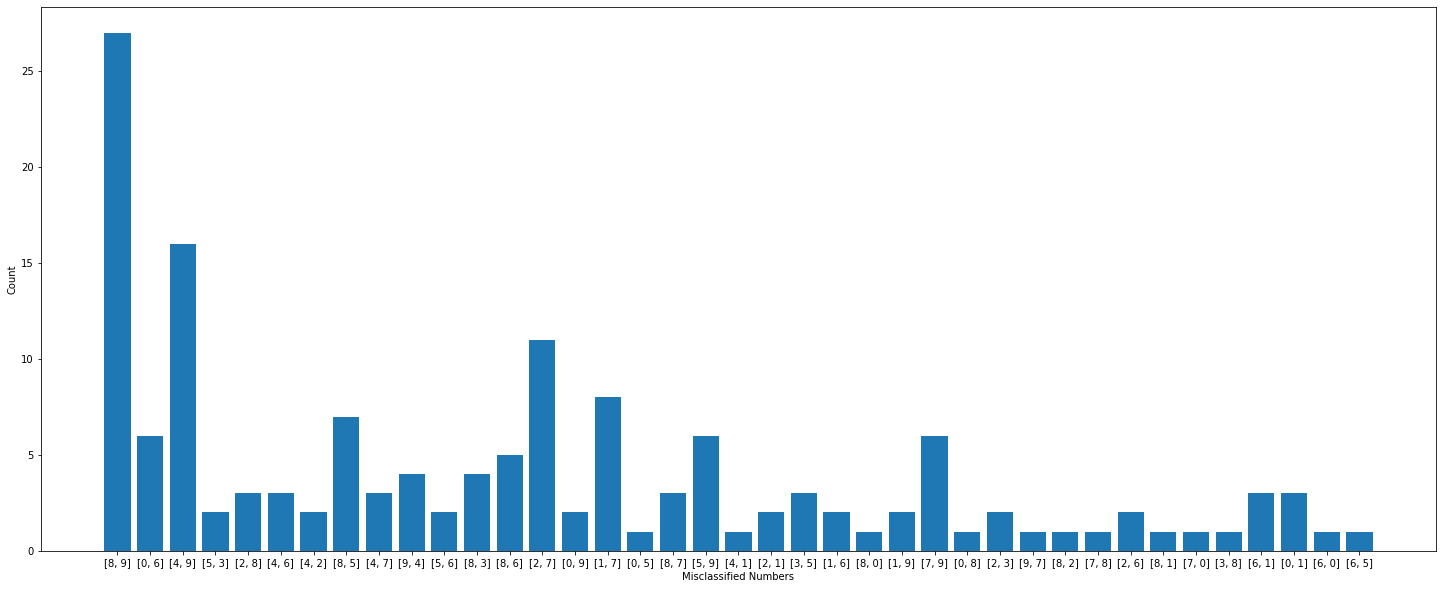

In [95]:
# Normal Misclasssifications
predictions_normal,wrong_inputs_normal,wrong_outputs_normal,wrong_outputs_original_normal,dic=find_misclassifications(mnist_model,test_X,test_y)

In [96]:
# Common Misclassifications
ss=sorted(dic.items(), key = lambda kv: kv[1],reverse=True)
ss[:5]

[('[8, 9]', 27), ('[4, 9]', 16), ('[2, 7]', 11), ('[1, 7]', 8), ('[8, 5]', 7)]

In [97]:
conv2D_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(mnist_model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]

In [98]:
val=[(ss[i][0],json.loads(ss[i][0])) for i in range(len(ss))]

@interact(misclass=val)
def misclassification(misclass):
    m_arr=create_misc_array(misclass[0],misclass[1],wrong_inputs_normal,wrong_outputs_normal,wrong_outputs_original_normal)
    plot_misclassifications(len(m_arr),m_arr,misclass)
    

interactive(children=(Dropdown(description='misclass', options=(('[8, 9]', [8, 9]), ('[4, 9]', [4, 9]), ('[2, …

In [99]:
val=[(ss[i][0],json.loads(ss[i][0])) for i in range(5)]

@interact(misclass=val,flag={'-6':0,'all':1,'last':2})
def misclassification(misclass,flag):
    xx=get_grad_array(wrong_inputs_normal,mnist_model,flag)
    m_arr=create_misc_array(misclass[0],misclass[1],xx,wrong_outputs_normal,wrong_outputs_original_normal)
    plot_misclassifications(len(m_arr),m_arr,misclass)

interactive(children=(Dropdown(description='misclass', options=(('[8, 9]', [8, 9]), ('[4, 9]', [4, 9]), ('[2, …

## Salt Model

In [106]:
(train_X_n, train_y_n), (test_X_n, test_y_n)= tf.keras.datasets.mnist.load_data()
train_X_salt= transform(train_X_n,noise=True)
test_X_salt= transform(test_X_n,noise=True)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_y_n.reshape(-1,1))
train_y_salt=enc.transform(train_y_n.reshape(-1,1)).toarray()
test_y_salt=enc.transform(test_y_n.reshape(-1,1)).toarray()
cats=enc.categories_
# train_X_salt = train_X
# train_y_salt = train_y
# test_X_salt = test_X
# test_y_salt = test_y

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


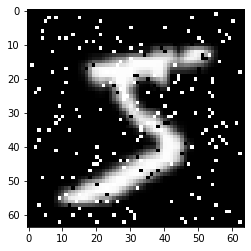

In [107]:
plt.imshow(train_X_salt[0])
print(train_y_salt[0])

In [108]:
mnist_sp_model=model_training(train_X_salt,train_y_salt,test_X_salt,test_y_salt,epochs=10)

Epoch 1/10
118/118 [==============================] - 27s 226ms/step - loss: 2.6467 - accuracy: 0.1506 - val_loss: 1.2202 - val_accuracy: 0.5755
Epoch 2/10
118/118 [==============================] - 27s 226ms/step - loss: 0.4716 - accuracy: 0.8460 - val_loss: 0.1969 - val_accuracy: 0.9414
Epoch 3/10
118/118 [==============================] - 27s 227ms/step - loss: 0.1172 - accuracy: 0.9650 - val_loss: 0.0888 - val_accuracy: 0.9740
Epoch 4/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0703 - accuracy: 0.9791 - val_loss: 0.0708 - val_accuracy: 0.9796
Epoch 5/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0560 - accuracy: 0.9839 - val_loss: 0.0574 - val_accuracy: 0.9839
Epoch 6/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0438 - accuracy: 0.9870 - val_loss: 0.0480 - val_accuracy: 0.9861
Epoch 7/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0343 - accuracy: 0.9896 - val_loss: 0.0470 - val_ac

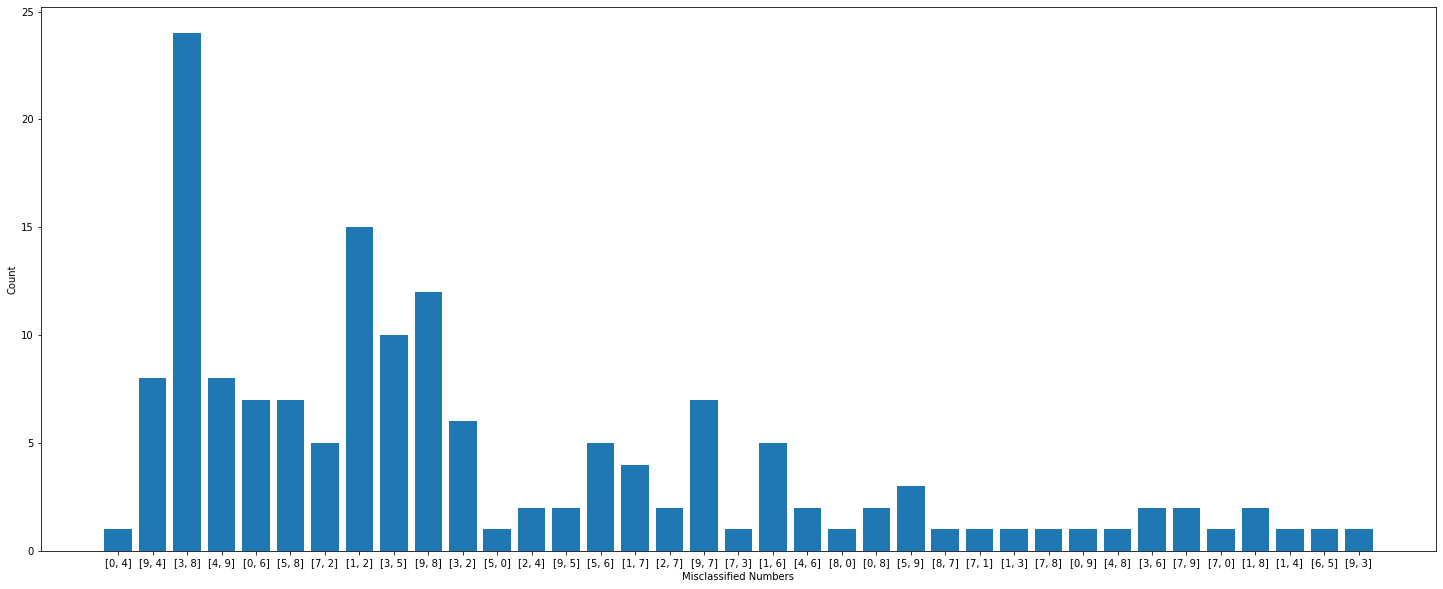

In [109]:
predictions_sp,wrong_inputs_sp,wrong_outputs_sp,wrong_outputs_original_sp,dic_sp=find_misclassifications(mnist_sp_model,test_X_salt,test_y_salt)

In [110]:
ss=sorted(dic_sp.items(), key = lambda kv: kv[1],reverse=True)
ss[:5]

[('[3, 8]', 24), ('[1, 2]', 15), ('[9, 8]', 12), ('[3, 5]', 10), ('[9, 4]', 8)]

In [114]:
val=[(ss[i][0],json.loads(ss[i][0])) for i in range(len(ss))]

@interact(misclass=val)
def misclassification(misclass):
    m_arr=create_misc_array(misclass[0],misclass[1],wrong_inputs_sp,wrong_outputs_sp,wrong_outputs_original_sp)
    plot_misclassifications(len(m_arr),m_arr,misclass)

interactive(children=(Dropdown(description='misclass', options=(('[3, 8]', [3, 8]), ('[1, 2]', [1, 2]), ('[9, …

In [115]:
val=[(ss[i][0],json.loads(ss[i][0])) for i in range(5)]

@interact(misclass=val,flag={'-6':0,'all':1,'last':2})
def misclassification(misclass,flag):
    xx=get_grad_array(wrong_inputs_sp,mnist_model,flag)
    m_arr=create_misc_array(misclass[0],misclass[1],xx,wrong_outputs_sp,wrong_outputs_original_sp)
    plot_misclassifications(len(m_arr),m_arr,misclass)

interactive(children=(Dropdown(description='misclass', options=(('[3, 8]', [3, 8]), ('[1, 2]', [1, 2]), ('[9, …

In [116]:
def get_wrong_predictions(test_y,test_X,test_X_noise,predictions_normal,predictions_noise):
    pred_ori=[]
    pred_as=[]
    norm_imgs=[]
    noise_imgs=[]
    for i in range(len(predictions_normal)):
        if np.argmax(predictions_normal[i])== np.argmax(test_y[i]):
            if np.argmax(predictions_normal[i]) != np.argmax(predictions_noise[i]):
                pred_ori.append(np.argmax(test_y[i]))
                pred_as.append(np.argmax(predictions_noise[i]))
                norm_imgs.append(test_X[i])
                noise_imgs.append(test_X_noise[i])
    return pred_ori,pred_as,norm_imgs,noise_imgs
    

In [117]:
pred_ori,pred_as,norm_imgs,noise_imgs=get_wrong_predictions(test_y,test_X,test_X_salt,predictions_normal,predictions_sp) 

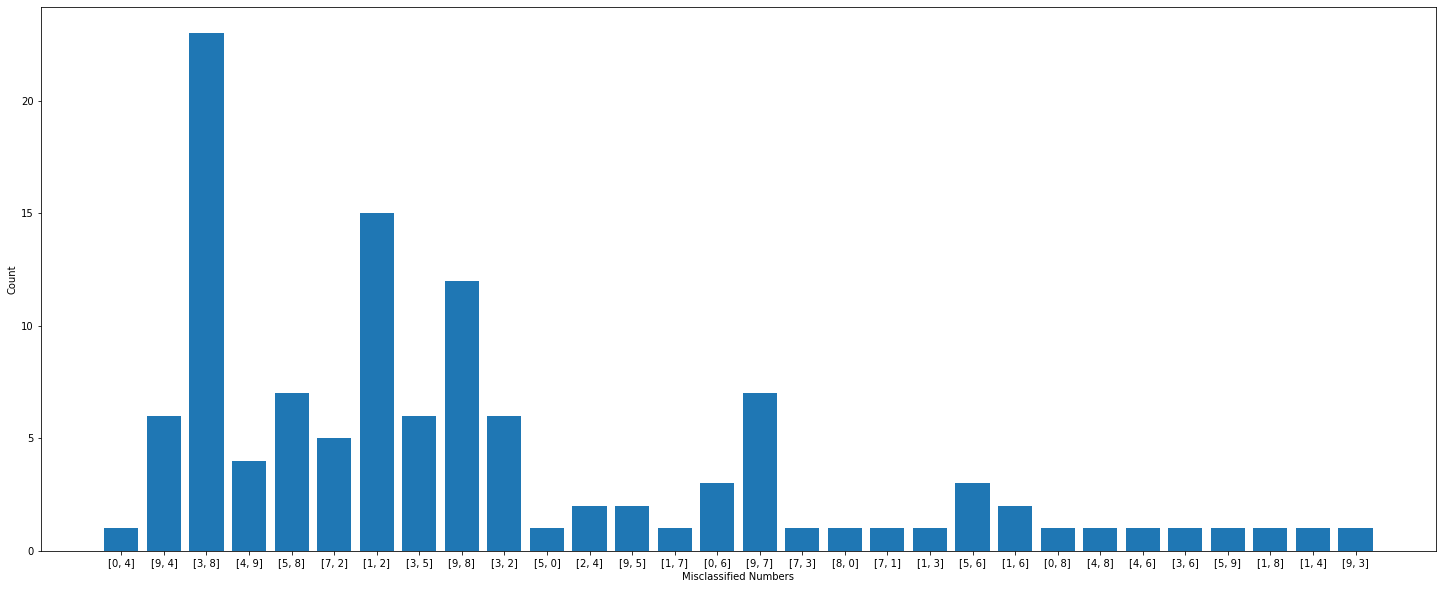

In [150]:
dic={}
for i in zip(pred_ori,pred_as):
    k=[int(i[1]),int(i[0])]
    s=json.dumps(k)
    try:
        dic[s]+=1
    except:
        dic[s]=1
plt.figure(figsize=(25,10))
plt.bar(range(len(dic)), list(dic.values()), align='center')
plt.xticks(range(len(dic)), list(dic.keys()))
plt.xlabel('Misclassified Numbers')
plt.ylabel('Count')
plt.show()

In [119]:
ss=sorted(dic.items(), key = lambda kv: kv[1],reverse=True)

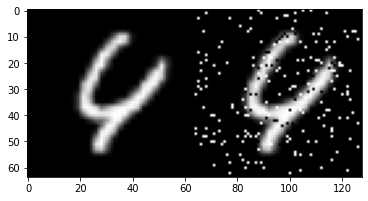

In [120]:
plt.imshow(np.concatenate((norm_imgs[1],noise_imgs[1]), axis = 1))

In [131]:
import shutil
shutil.rmtree('Error_images')
os.mkdir('Error_images')
for k in dic.keys():
    os.mkdir('Error_images/'+k)

In [132]:
import shutil
shutil.rmtree('Error_images_grad')
os.mkdir('Error_Images_grad')
for k in dic.keys():
    os.mkdir('Error_Images_grad/'+k)

In [133]:
count=0
for i in range(len(norm_imgs)):
    img_folder= json.dumps([int(pred_ori[i]),int(pred_as[i])])
    conc_img=np.concatenate((norm_imgs[i]/255.,noise_imgs[i]/255.), axis = 1)
    plt.imsave(os.path.join('Error_Images',img_folder,f'{count}.jpg'),conc_img)
    count+=1

## Gaussian Model

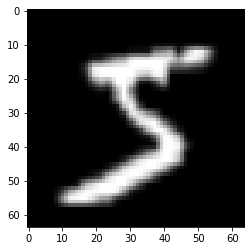

In [149]:
xxx=np.zeros((64,64,3),dtype=np.uint8)
xxx[:,:,0]=train_X[0][:,:,0]+gaus
xxx[:,:,1]=train_X[0][:,:,1]+gaus
xxx[:,:,2]=train_X[0][:,:,2]+gaus
cv2.normalize(xxx,xxx,0, 255, cv2.NORM_MINMAX, dtype=-1)
plt.imshow(xxx)

In [156]:
(train_X_n, train_y_n), (test_X_n, test_y_n)= tf.keras.datasets.mnist.load_data()
train_X_gaus= transform(train_X_n,noise=True,nt='g')
test_X_gaus= transform(test_X_n,noise=True,nt='g')
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_y_n.reshape(-1,1))
train_y_gaus=enc.transform(train_y_n.reshape(-1,1)).toarray()
test_y_gaus=enc.transform(test_y_n.reshape(-1,1)).toarray()

In [157]:
mnist_gaus_model=model_training(train_X_gaus,train_y_gaus,test_X_gaus,test_y_gaus,epochs=10)

Epoch 1/10
118/118 [==============================] - 63s 527ms/step - loss: 2.3188 - accuracy: 0.2726 - val_loss: 0.7849 - val_accuracy: 0.7152
Epoch 2/10
118/118 [==============================] - 44s 374ms/step - loss: 0.3597 - accuracy: 0.8824 - val_loss: 0.1263 - val_accuracy: 0.9624
Epoch 3/10
118/118 [==============================] - 27s 227ms/step - loss: 0.0875 - accuracy: 0.9735 - val_loss: 0.0678 - val_accuracy: 0.9801
Epoch 4/10
118/118 [==============================] - 27s 227ms/step - loss: 0.0564 - accuracy: 0.9829 - val_loss: 0.0490 - val_accuracy: 0.9857
Epoch 5/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0413 - accuracy: 0.9877 - val_loss: 0.0326 - val_accuracy: 0.9911
Epoch 6/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0503 - val_accuracy: 0.9864
Epoch 7/10
118/118 [==============================] - 27s 228ms/step - loss: 0.0303 - accuracy: 0.9910 - val_loss: 0.0419 - val_ac

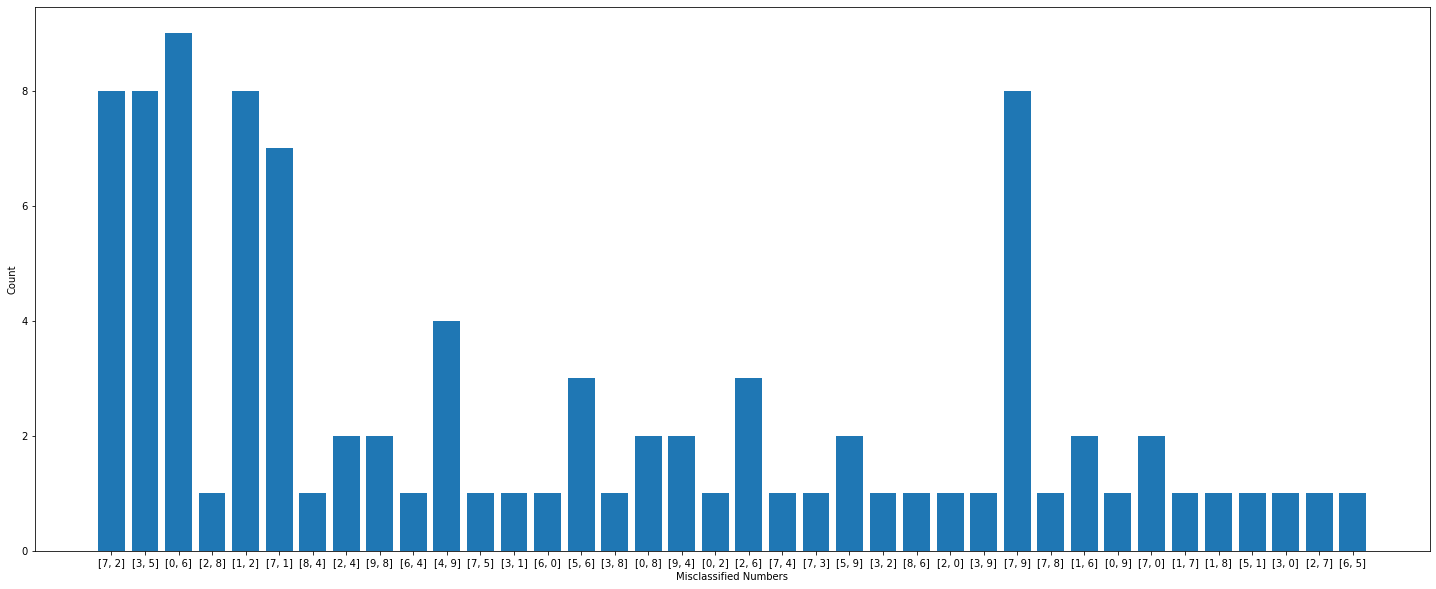

In [159]:
predictions_g,wrong_inputs_g,wrong_outputs_g,wrong_outputs_original_g,dic_g=find_misclassifications(mnist_gaus_model,test_X_gaus,test_y_gaus)

In [161]:
pred_ori,pred_as,norm_imgs,noise_imgs=get_wrong_predictions(test_y,test_X,test_X_gaus,predictions_normal,predictions_g) 

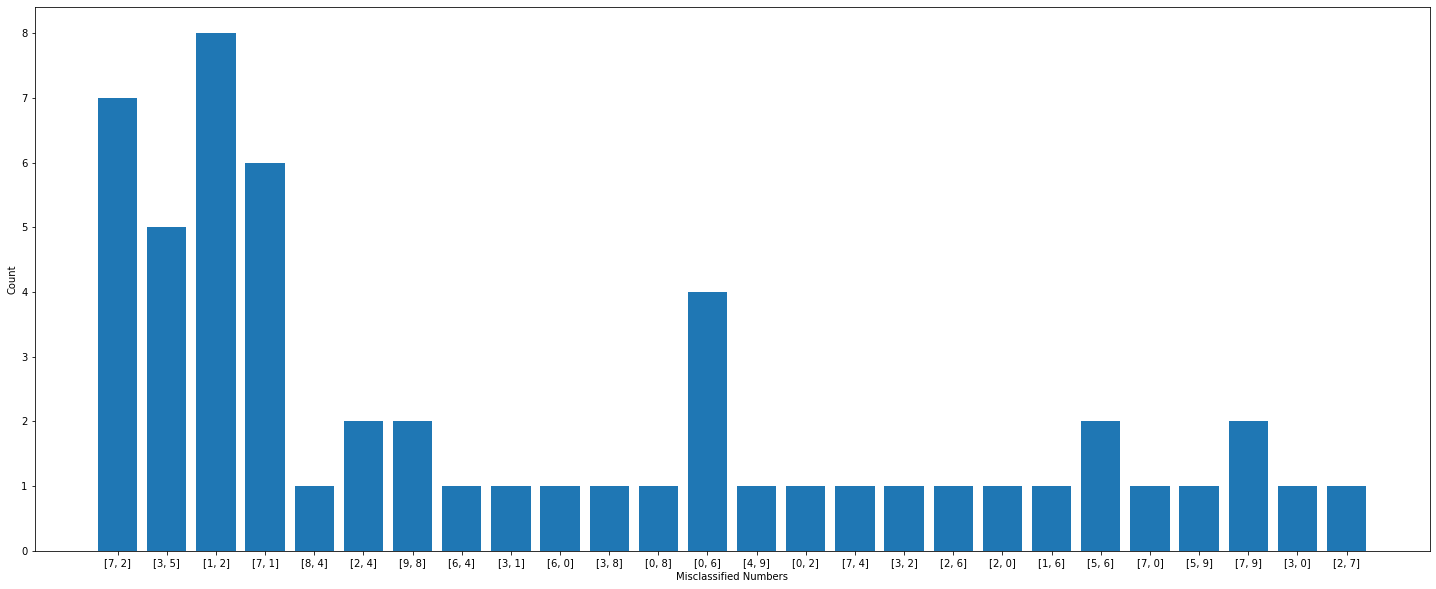

In [162]:
dic={}
for i in zip(pred_ori,pred_as):
    k=[int(i[1]),int(i[0])]
    s=json.dumps(k)
    try:
        dic[s]+=1
    except:
        dic[s]=1
plt.figure(figsize=(25,10))
plt.bar(range(len(dic)), list(dic.values()), align='center')
plt.xticks(range(len(dic)), list(dic.keys()))
plt.xlabel('Misclassified Numbers')
plt.ylabel('Count')
plt.show()

In [163]:
ss=sorted(dic.items(), key = lambda kv: kv[1],reverse=True)

In [166]:
import shutil
#shutil.rmtree('Error_images_grad_gaus')
#shutil.rmtree('Error_images_gaus')
os.mkdir('Error_Images_grad_gaus')
for k in dic.keys():
    os.mkdir('Error_Images_grad_gaus/'+k)
os.mkdir('Error_Images_gaus')
for k in dic.keys():
    os.mkdir('Error_Images_gaus/'+k)

In [168]:
count=0
for i in range(len(norm_imgs)):
    img_folder= json.dumps([int(pred_as[i]),int(pred_ori[i])])
    conc_img=np.concatenate((norm_imgs[i]/255.,noise_imgs[i]/255.), axis = 1)
    plt.imsave(os.path.join('Error_Images_gaus',img_folder,f'{count}.jpg'),conc_img)
    count+=1

In [169]:
count=0
for i in range(len(norm_imgs)):
    img_folder= json.dumps([int(pred_as[i]),int(pred_ori[i])])
    sp_norm,cams_norm=fuse_layers(conv2D_layers,mnist_model,cv2.cvtColor(norm_imgs[i].astype('float32'), cv2.COLOR_RGB2BGR))
    sp_noise,cams_noise=fuse_layers(conv2D_layers,mnist_model,cv2.cvtColor(noise_imgs[i].astype('float32'), cv2.COLOR_RGB2BGR))
    conc_img=np.concatenate((sp_norm,sp_noise), axis = 1)
    plt.imsave(os.path.join('Error_Images_grad_gaus',img_folder,f'{count}.jpg'),conc_img.astype(np.uint8))
    count+=1